# 1D CNN-based AEs (CAE) for 12Kb windows

In the notebook I am comparing three different CAE architectures

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

assembly = 'hg19'
window_size = 12000
step_freq = 2
resolution = 100
test_ratio = 0.1
chroms = [
  'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
  'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
  'chr20', 'chr21', 'chr22', 'chrX', 'chrY'
]
chroms = ['chr22'] # testing only! comment out for real training
rnd_seed = 123
dev_set_size = 0.075 # i.e., 7.5% of all windows
test_set_size = 0.075 # i.e., 7.5% of all windows

step_size = window_size // step_freq
bins_per_window = window_size // resolution

## Load and normalize the data

#### Download dataset

In [9]:
import wget
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

print('Download data.', end='', flush=True)

# GM12878 DNase-seq read-depth normalized signal
bw = 'data/ENCFF158GBQ.bigWig'
if not Path(bw).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF158GBQ/@@download/ENCFF158GBQ.bigWig',
        'data/ENCFF158GBQ.bigWig',
    )
    
print('.', end='', flush=True)
    
bb1 = 'data/ENCFF246MAX.bigBed'
if not Path(bb1).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF246MAX/@@download/ENCFF246MAX.bigBed',
        'data/ENCFF246MAX.bigBed',
    )
    
print('.', end='', flush=True)
    
bb2 = 'data/ENCFF541CUW.bigBed'
if not Path(bb2).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF541CUW/@@download/ENCFF541CUW.bigBed',
        'data/ENCFF541CUW.bigBed',
    )

print(' done!')

Download data... done!


#### Sanity check

that all the previously defined chromosomes are available in the bigWig file

In [10]:
from server import bigwig

chrom_sizes_bw = bigwig.get_chromsizes(bw)
chrom_sizes_bb1 = bigwig.get_chromsizes(bb1)
chrom_sizes_bb2 = bigwig.get_chromsizes(bb2)

# Sanity check
for chrom in chroms:
    if not chrom in chrom_sizes_bw:
        print('WARNING: {} not found in {}!'.format(chrom, bw))
    if not chrom in chrom_sizes_bb1:
        print('WARNING: {} not found in {}!'.format(chrom, bb1))
    if not chrom in chrom_sizes_bb2:
        print('WARNING: {} not found in {}!'.format(chrom, bb2))

#### Extract the binned genomic windows

In [11]:
from server import bigwig

print('Extract windows...')

data = bigwig.chunk(
    bw,
    window_size,
    resolution,
    step_size,
    chroms,
    normalize=True,
    verbose=True,
)

print('Done!')

Extract windows...
Extracted 8550 windows from chr22 with a max value of 1.0.
Done!


2733 windows ar empty


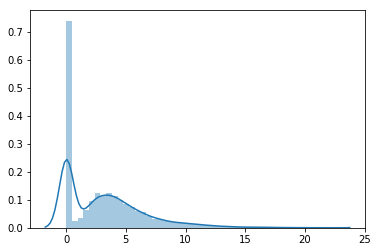

In [14]:
import seaborn as sns

win_sum = np.sum(data, axis=1)
print('{} windows are empty'.format(np.sum(win_sum == 0)))
sns.distplot(win_sum)

#### Balance windows

Randomly filter out regions that are not annotated with (broad or narrow) peaks and that do not contain a lot of signal.

First extract the peaks per window.

In [13]:
from ae import utils
import time

start_time = time.time()

print('Extract narrow peak windows...')

narrow_peaks = utils.chunk_beds_binary(
    bb1,
    window_size,
    step_size,
    chroms,
    verbose=True,
)

print('\nExtract broad peak windows...')

broad_peaks = utils.chunk_beds_binary(
    bb2,
    window_size,
    step_size,
    chroms,
    verbose=True,
)

print('Done!')

end_time = time.time()

print('Took {0:.2f} seconds'.format(end_time - start_time))

Using TensorFlow backend.


Extract narrow peak windows...
Extracted 8550 windows from chr22 with a max value of 1.0.

Extract broad peak windows...
Extracted 8550 windows from chr22 with a max value of 1.0.
Done!
Took 0.05 seconds


Next filter out windows that do not contain any peaks and that only have weak signal.

In [18]:
win_with_narrow_or_broad_peaks = (narrow_peaks + broad_peaks).flatten()

# Total signal per window
win_sum = np.sum(data, axis=1)

has_peaks = win_with_narrow_or_broad_peaks > 0
no_peaks = win_with_narrow_or_broad_peaks == 0

win_sum_has_peaks = win_sum[has_peaks] # Total signal per window of windows with peaks
win_sum_no_peaks = win_sum[no_peaks] # Total signal per window of windows without peaks

# Select all windows where the total signal is at least 25 percentile
# of the windows containing at least 1 peak.
win_sum_gt_25p = win_sum > np.percentile(win_sum[has_peaks], 25)
win_sum_is_zero = win_sum == 0

num_total_win = data.shape[0]

pos_win = has_peaks | win_sum_gt_25p
pos_win_no = np.arange(num_total_win)[pos_win]
neg_not_empty_win = ~pos_win & ~win_sum_is_zero
neg_not_empty_win_no = np.arange(num_total_win)[neg_not_empty_win]
neg_empty_win = ~pos_win & win_sum_is_zero
neg_empty_win_no = np.arange(num_total_win)[neg_empty_win]

to_be_sampled = np.min(
    [
        # Do not sample more than the complete number of negative but non-empty
        # windows
        np.max([0, np.sum(neg_not_empty_win)]),
        np.max(
            [
                # Sample at most half as many windows as windows with peak
                # annotations. This is only necessary when there are few windows
                # with annotated peaks but a lot of windows where the total signal
                # is larger than 25-percentile of the total signal of windows with
                # peaks
                np.sum(has_peaks) * 0.5,
                np.min([2 * np.sum(has_peaks) - np.sum(pos_win), np.sum(~pos_win)]),
            ]
        ),
    ]
).astype(int)
to_be_sampled_not_empty = np.ceil(to_be_sampled * 0.95).astype(int)
to_be_sampled_empty = to_be_sampled - to_be_sampled_not_empty

neg_not_empty_win_no_subsample = np.random.choice(
    neg_not_empty_win_no,
    to_be_sampled_not_empty,
    replace=False
)

neg_empty_win_no_subsample = np.random.choice(
    neg_empty_win_no,
    to_be_sampled_empty,
    replace=False
)

selected_win = np.sort(
    np.concatenate((pos_win_no, neg_not_empty_win_no_subsample, neg_empty_win_no_subsample))
)

# Most important: lets filter the actual windows
data_filtered = data[selected_win]
win_has_peaks_filtered = has_peaks[selected_win]

print('{} out of {} {} kb windows are used for training.'.format(
    data_filtered.shape[0],
    data.shape[0],
    window_size / 1000
))

5817 out of 8550 12.0 kb windows are used for training.


#### Visualize the results of the filtering

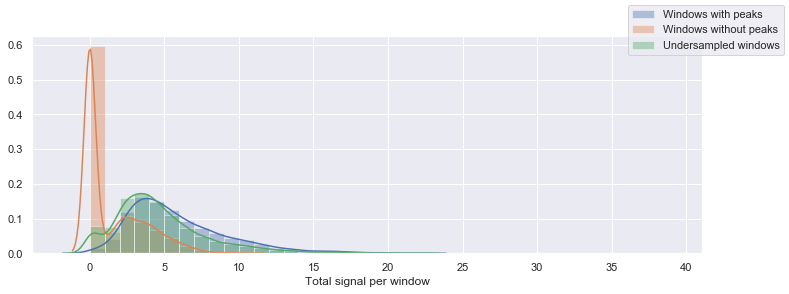

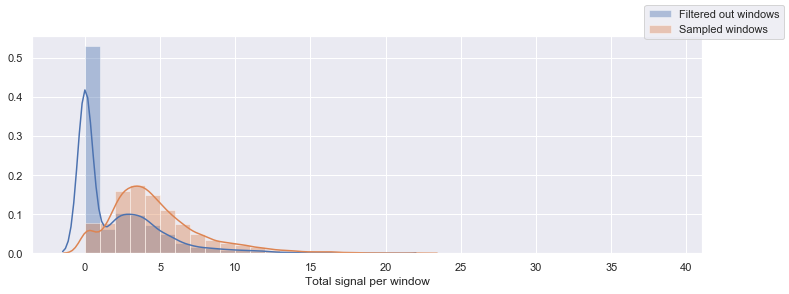

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=20) 

sns.set();

fig = plt.figure(figsize=(12, 4))
sns.distplot(win_sum_has_peaks, bins=np.arange(40), label='Windows with peaks')
sns.distplot(win_sum_no_peaks, bins=np.arange(40), label='Windows without peaks')
sns.distplot(win_sum[selected_win], bins=np.arange(40), label='Undersampled windows')
plt.xlabel('Total signal per window')
fig.legend()

fig = plt.figure(figsize=(12, 4))
sns.distplot(win_sum[~selected_win], bins=np.arange(40), label='Filtered out windows')
sns.distplot(win_sum[selected_win], bins=np.arange(40), label='Sampled windows')
plt.xlabel('Total signal per window')
fig.legend()

#### Split data into train, dev, test

We are going to use 80% for training, 10% for dev, and 10% for testing.

In [20]:
total_num_filtered_windows = data_filtered.shape[0]
shuffling = np.arange(total_num_filtered_windows)

# Shuffle window ids and use the shuffled ids to shuffle the window data and window peaks
np.random.seed(rnd_seed)
np.random.shuffle(shuffling)
data_filtered_shuffled = data_filtered[shuffling]
win_has_peaks_filtered_shuffled = win_has_peaks_filtered[shuffling]

# Split into train, dev, and test set
split_1 = int((1.0 - dev_set_size - test_set_size) * total_num_filtered_windows)
split_2 = int((1.0 - test_set_size) * total_num_filtered_windows)

data_train = data_filtered_shuffled[:split_1]
peaks_train = win_has_peaks_filtered_shuffled[:split_1]
data_dev = data_filtered_shuffled[split_1:split_2]
peaks_dev = win_has_peaks_filtered_shuffled[split_1:split_2]
data_test = data_filtered_shuffled[split_2:]
peaks_test = win_has_peaks_filtered_shuffled[split_2:]

print('Train: {} (with {:.2f}% peaks) Dev: {} (with {:.2f}% peaks) Test: {} (with {:.2f}% peaks)'.format(
    data_train.shape[0],
    np.sum(peaks_train) / peaks_train.shape[0] * 100,
    data_dev.shape[0],
    np.sum(peaks_dev) / peaks_dev.shape[0] * 100,
    data_test.shape[0],
    np.sum(peaks_test) / peaks_test.shape[0] * 100,
))

Train: 4944 (with 57.83% peaks) Dev: 436 (with 60.32% peaks) Test: 437 (with 58.81% peaks)


## Define different CAEs for comparison

In [ ]:
# Load models

In [23]:
# Building CAE

from ae.cnn import cnn2

encoder1, decoder1, autoencoder1 = cnn2(
    (window_size // aggregation, 1),
    filters=[32, 64, 128, 10],
    kernel_sizes=[11, 7, 3],
    summary=False,
    dr=True
)

encoder2, decoder2, autoencoder2 = cnn2(
    (window_size // aggregation, 1),
    filters=[32, 64, 128, 6],
    kernel_sizes=[11, 9, 5],
    summary=False,
    dr=True
)

encoder3, decoder3, autoencoder3 = cnn2(
    (window_size // aggregation, 1),
    filters=[32, 64, 128, 6],
    kernel_sizes=[9, 5, 3],
    summary=False,
    dr=True
)

## Train the CAEs

In [25]:
from ae.utils import train

epochs = 1
batch_size = 256

train(
    autoencoder1,
    data_train_norm_filt.reshape(data_train_norm_filt.shape[0], data_train_norm_filt.shape[1], 1),
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

train(
    autoencoder2,
    data_train_norm_filt.reshape(data_train_norm_filt.shape[0], data_train_norm_filt.shape[1], 1),
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

train(
    autoencoder3,
    data_train_norm_filt.reshape(data_train_norm_filt.shape[0], data_train_norm_filt.shape[1], 1),
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    epochs=epochs,
    batch_size=batch_size,
)

Train on 20488 samples, validate on 8550 samples
Epoch 1/1
20488/20488 [==============================] - 26s 1ms/step - loss: 0.2511 - val_loss: 0.1266
Train on 20488 samples, validate on 8550 samples
Epoch 1/1
20488/20488 [==============================] - 36s 2ms/step - loss: 0.2508 - val_loss: 0.1368
Train on 20488 samples, validate on 8550 samples
Epoch 1/1
20488/20488 [==============================] - 26s 1ms/step - loss: 0.2530 - val_loss: 0.1326


#### Save the models

In [7]:
# encoder1.save('models/encode-gm12878-dnase-seq-2011-encoder-chr1-chr22-new-cnn.h5')
# decoder1.save('models/encode-gm12878-dnase-seq-2011-decoder-chr1-chr22-new-cnn.h5')
# autoencoder1.save('models/encode-gm12878-dnase-seq-2011-autoencoder-chr1-chr22-new-cnn.h5')

## Predict encodings

In [28]:
from keras.metrics import binary_crossentropy
from ae.utils import predict

predicted1, loss1, _ = predict(
    encoder1,
    decoder1,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted1 = predicted1.reshape(predicted1.shape[0], predicted1.shape[1])

predicted2, loss2, _ = predict(
    encoder2,
    decoder2,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted2 = predicted2.reshape(predicted2.shape[0], predicted2.shape[1])

predicted2, loss2, _ = predict(
    encoder2,
    decoder2,
    data_test_norm.reshape(data_test_norm.shape[0], data_test_norm.shape[1], 1),
    validator=binary_crossentropy
)
predicted2 = predicted2.reshape(predicted2.shape[0], predicted2.shape[1])

## Visualize preditions

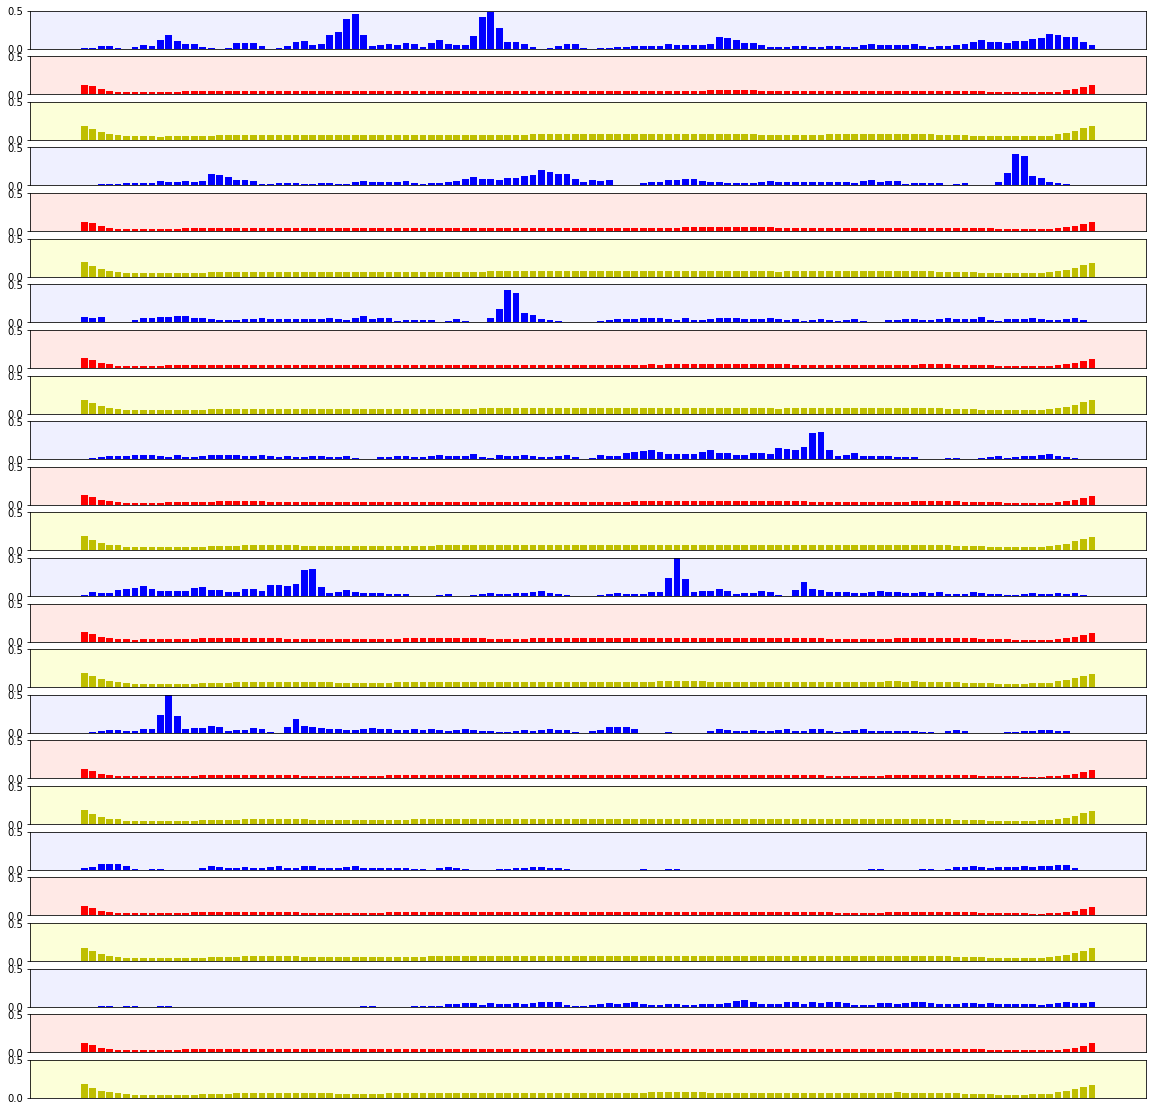

In [31]:
import matplotlib.pyplot as plt

n = 8
offset = 5920

ymax = 0.5

plt.figure(figsize=(20, 20))
for i in range(n):
    k = i + offset
    
    # display original
    ax = plt.subplot(n * 3, 1, i * 3 + 1)
    ax.set_facecolor('#EFF0FF')
    plt.bar(np.arange(data_test_norm[k].size), data_test_norm[k], color='b')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n * 3, 1, i * 3 + 2)
    ax.set_facecolor('#FFE9E6')
    plt.bar(np.arange(predicted1[k].size), predicted1[k], color='r')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n * 3, 1, i * 3 + 3)
    ax.set_facecolor('#FCFFD9')
    plt.bar(np.arange(predicted2[k].size), predicted2[k], color='y')
    plt.ylim(0, ymax)
    ax.get_xaxis().set_visible(False)
plt.show()

#### Visualize the best and worse windows in terms of loss

The top blueish plots show the best predictions and the redish ones at the bottom show the worse predictions. The ground truth is plotted semi-transparently in gray.

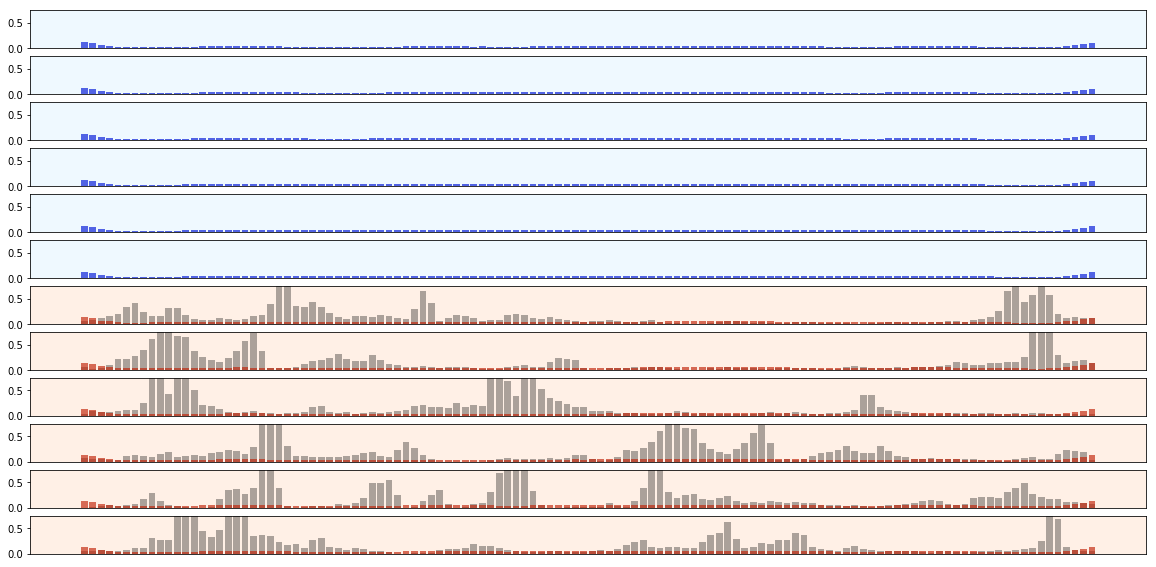

In [41]:
import matplotlib.pyplot as plt

examples = 6
n = examples * 2

best_worst = np.argsort(loss1)
best_worst = np.concatenate((best_worst[:examples], best_worst[-examples:]))

plt.figure(figsize=(20, 10))
for i, k in enumerate(best_worst):
    ymax = np.max(data_test_norm[k])
    
    if i < examples:
        ca = '#000000'
        bgca = '#eff9ff'
        cb = '#0015d6'
    else:
        ca = '#000000'
        bgca = '#fff0e6'
        cb = '#c12409'
    
    # display original
    ax = plt.subplot(n, 1, i + 1)
    ax.set_facecolor(bgca)
    plt.bar(np.arange(data_test_norm[i].size), data_test_norm[k], color=ca, alpha=0.33)
    plt.bar(np.arange(predicted1[k].size), predicted1[k], color=cb, alpha=0.66)
    plt.ylim(0, 0.75)
    ax.get_xaxis().set_visible(False)
plt.show()